In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from tensorflow import keras

In [2]:
di = pd.read_csv('/content/data_covid_indo.csv', sep=',')
di.head()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,52837,IDN,Asia,Indonesia,2020-03-02,2.0,2.0,NaN,NaN,NaN,NaN,0.007,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.70,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN,NaN,NaN,NaN
1,52838,IDN,Asia,Indonesia,2020-03-03,2.0,0.0,NaN,NaN,NaN,NaN,0.007,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN,NaN,NaN,NaN
2,52839,IDN,Asia,Indonesia,2020-03-04,2.0,0.0,NaN,NaN,NaN,NaN,0.007,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN,NaN,NaN,NaN
3,52840,IDN,Asia,Indonesia,2020-03-05,2.0,0.0,NaN,NaN,NaN,NaN,0.007,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN,NaN,NaN,NaN
4,52841,IDN,Asia,Indonesia,2020-03-06,4.0,2.0,NaN,NaN,NaN,NaN,0.014,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN,NaN,NaN,NaN


In [3]:
di.columns

Index(['Unnamed: 0', 'iso_code', 'continent', 'location', 'date',
       'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smooth

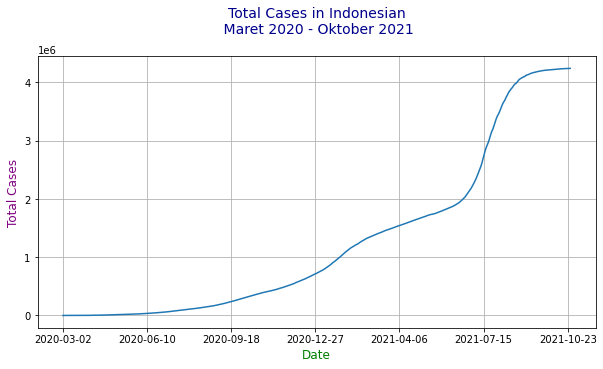

In [4]:
di['date'] = pd.to_datetime(di['date'])
di_string_date = di.copy()
di_string_date['date'] = di['date'].dt.date.astype(np.str)
di_string_date = di_string_date.groupby('date').sum()

plt.figure(figsize=(10, 5))
di_string_date['total_cases'].plot()
plt.title('Total Cases in Indonesian\n Maret 2020 - Oktober 2021\n', fontsize=14, color='darkblue')
plt.ylabel('Total Cases', fontsize=12, color='purple')
plt.xlabel('Date', fontsize=12, color='green')
plt.grid()
plt.savefig('Total Cases.png')
plt.show()

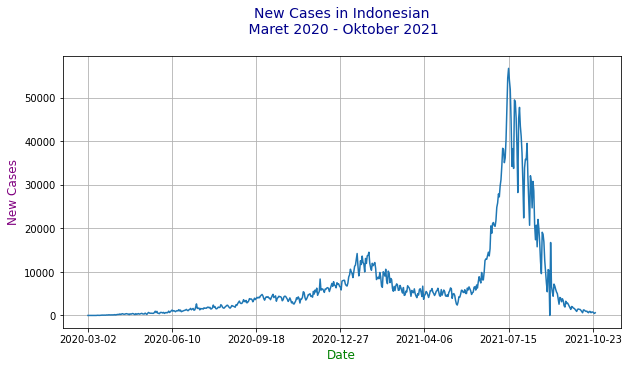

In [5]:
plt.figure(figsize=(10, 5))
di_string_date['new_cases'].plot()
plt.title('New Cases in Indonesian\n Maret 2020 - Oktober 2021\n', fontsize=14, color='darkblue')
plt.ylabel('New Cases', fontsize=12, color='purple')
plt.xlabel('Date', fontsize=12, color='green')
plt.grid()
plt.savefig('New Cases.png')
plt.show()

In [6]:
max_new_cases = di_string_date[di_string_date['new_cases']==di_string_date['new_cases'].max()]
max_new_cases.rename(columns={'Unnamed: 0':'nomor'})

,nomor,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-15,53337,2726803.0,56757.0,44145.0,70192.0,982.0,918.857,9866.787,205.372,159.736,253.986,3.553,3.325,1.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185321.0,15288045.0,55.319,0.671,150886.0,0.546,0.293,3.4,55819781.0,39943004.0,15876777.0,0.0,1298794.0,905228.0,20.2,14.45,5.74,0.0,3276.0,68.98,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,0.0,0.0,0.0,0.0


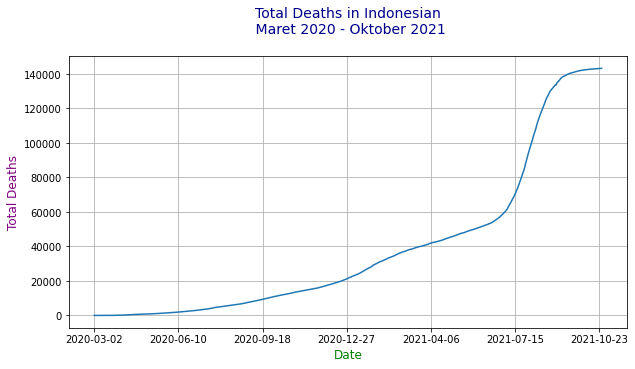

In [7]:
plt.figure(figsize=(10, 5))
di_string_date['total_deaths'].plot()
plt.title('Total Deaths in Indonesian\n Maret 2020 - Oktober 2021\n', fontsize=14, color='darkblue')
plt.ylabel('Total Deaths', fontsize=12, color='purple')
plt.xlabel('Date', fontsize=12, color='green')
plt.grid()
plt.savefig('Total Deaths.png')
plt.show()

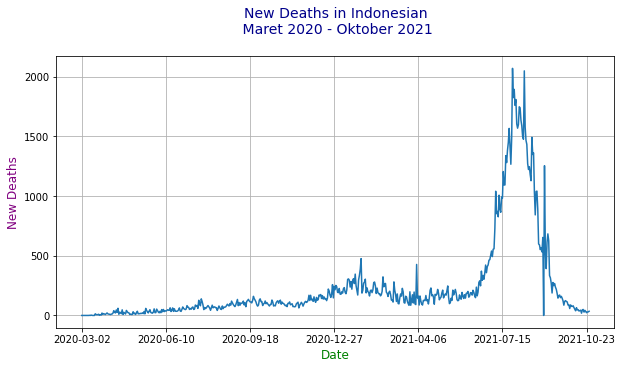

In [8]:
plt.figure(figsize=(10, 5))
di_string_date['new_deaths'].plot()
plt.title('New Deaths in Indonesian\n Maret 2020 - Oktober 2021\n', fontsize=14, color='darkblue')
plt.ylabel('New Deaths', fontsize=12, color='purple')
plt.xlabel('Date', fontsize=12, color='green')
plt.grid()
plt.savefig('New Deaths.png')
plt.show()

In [9]:
max_new_deaths = di_string_date[di_string_date['new_deaths']==di_string_date['new_deaths'].max()]
max_new_deaths.rename(columns={'Unnamed: 0':'nomor'})

,nomor,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-27,53349,3239936.0,45203.0,41411.143,86835.0,2069.0,1519.286,11723.531,163.565,149.844,314.208,7.487,5.497,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159549.0,0.577,0.26,3.9,63944892.0,45278549.0,18666343.0,0.0,1086694.0,732901.0,23.14,16.38,6.75,0.0,2652.0,68.98,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,0.0,0.0,0.0,0.0


In [10]:
di_string_date['day'] = pd.DatetimeIndex(di_string_date.index).day
di_string_date['month'] = pd.DatetimeIndex(di_string_date.index).month
di_string_date['year'] = pd.DatetimeIndex(di_string_date.index).year

df_ml = di_string_date.copy()
df_ml = df_ml[['day','month','year','new_cases']]
df_ml.reset_index(drop=True, inplace=True)
df_ml.to_csv('df_ml.csv')



---



In [11]:
df = pd.read_csv('/content/df_ml.csv', sep=',')
df = df.drop(columns=['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
df

,day,month,year,new_cases
0,2,3,2020,2.0
1,3,3,2020,0.0
2,4,3,2020,0.0
3,5,3,2020,0.0
4,6,3,2020,2.0
...,...,...,...,...
599,22,10,2021,760.0
600,23,10,2021,802.0
601,24,10,2021,623.0
602,25,10,2021,460.0


In [12]:
def split_sequence(sequence, n_steps=3):
    sequence = list(sequence)
    X, Y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        Y.append(seq_y)
    def reshape(d):
        d = np.array(d)
        d = np.reshape(d,(d.shape[0], d.shape[1],1))
        return d
    return reshape(X), np.array(Y)
train_data = df['new_cases'].iloc[:423]
test_data = df['new_cases'].iloc[181:]
x_train, y_train = split_sequence(train_data)
x_test, y_test = split_sequence(test_data)
model = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(3,1,), activation='relu', return_sequences=True),
    keras.layers.LSTM(64, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [13]:
stoping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[stoping], verbose=2)

Epoch 1/100
14/14 - 2s - loss: 25978248.0000
Epoch 2/100
14/14 - 0s - loss: 23119506.0000
Epoch 3/100
14/14 - 0s - loss: 14070585.0000
Epoch 4/100
14/14 - 0s - loss: 1730872.5000
Epoch 5/100
14/14 - 0s - loss: 733466.3750
Epoch 6/100
14/14 - 0s - loss: 786150.8750
Epoch 7/100
14/14 - 0s - loss: 742643.3750
Epoch 8/100
14/14 - 0s - loss: 742728.7500


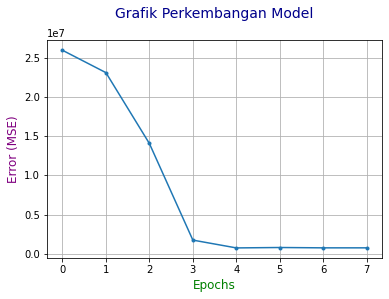

In [14]:
plt.plot(history.history['loss'], marker='.')
plt.title('Grafik Perkembangan Model\n', fontsize = 14, color = 'darkblue')
plt.xlabel('Epochs', fontsize = 12, color = 'green')
plt.ylabel('Error (MSE)', fontsize = 12, color = 'purple')
plt.grid()
plt.savefig('Training NN Model.png')
plt.show()

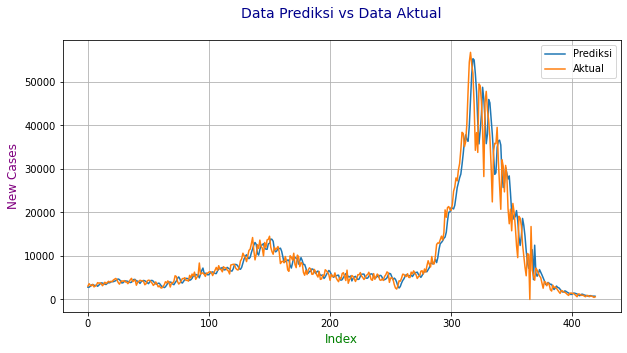

In [15]:
plt.figure(figsize=(10,5))
plt.plot(model.predict(x_test), label='Prediksi')
plt.plot(y_test, label='Aktual')
plt.legend()
plt.grid()
plt.title('Data Prediksi vs Data Aktual\n', fontsize = 14, color = 'darkblue')
plt.xlabel('Index', fontsize = 12, color = 'green')
plt.ylabel('New Cases', fontsize = 12, color = 'purple')
plt.savefig('Demonstrasi Prediksi NN Model.png')
plt.show()

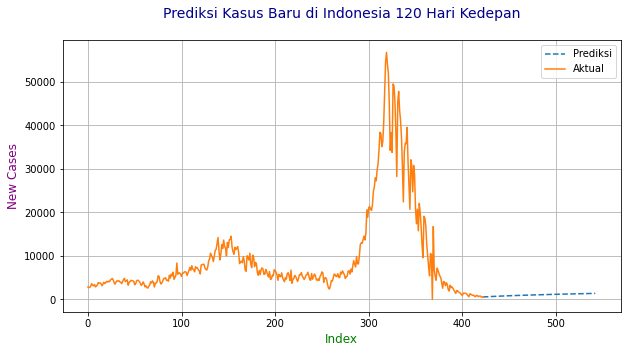

In [16]:
def predict_future(shift_count):
    def reshape(three):
        return np.array(three).reshape(1,3,1)
    array = list(df['new_cases']) + []
    now = len(df['new_cases'])-3
    last = len(df['new_cases'])
    for _ in range(shift_count):
        converted = reshape(array[now:last])
        array.append(model.predict(converted)[0][0])
        now += 1
        last += 1
    return array
    
future_prediction = predict_future(120)
plt.figure(figsize=(10,5))
plt.plot(np.arange(422,543), future_prediction[-121:], '--', label='Prediksi')
plt.plot(np.arange(423), df['new_cases'][-423:], label='Aktual')
plt.title('Prediksi Kasus Baru di Indonesia 120 Hari Kedepan\n', fontsize = 14, color = 'darkblue')
plt.xlabel('Index', fontsize = 12, color = 'green')
plt.ylabel('New Cases', fontsize = 12, color = 'purple')
plt.grid()
plt.savefig('Prediksi Dengan NN Model.png')
plt.legend();